# Policy Optimization

Here we show a simple policy optimization example using the `NNPolicy` and the `FirstOrderNNPolicyOptimizer`. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from score_po.policy_optimizer import (
    PolicyOptimizerParams,
    FirstOrderNNPolicyOptimizer)
from score_po.dynamical_system import DynamicalSystem
from score_po.costs import QuadraticCost
from score_po.policy import NNPolicy
from score_po.nn import MLP

We'll define the parameters first, which includes the horizon, batch size, rate, etc. 
We will use `params.x0_upper` and `params.x0_lower` as limits of a uniform distribution.

In [4]:
params = PolicyOptimizerParams()
params.T = 20
params.x0_upper = torch.Tensor([0.5, 0.5])
params.x0_lower = -torch.Tensor([0.5, 0.5])
params.batch_size = 512
params.std = 1e-2
params.lr = 1e-8
params.max_iters = 200

Now we'll set up the dynamical system. We will choose the simple system of $f(x,u) = x + u$. To define this system, you'll need to make your own `DynamicalSystem` class and pass it onto `params`.

In [5]:
# 1. Set up dynamical system.
class SingleIntegrator(DynamicalSystem):
    def __init__(self):
        super().__init__(2, 2)
        self.is_differentiable = True

    def dynamics(self, x, u):
        return x + u

    def dynamics_batch(self, x_batch, u_batch):
        return x_batch + u_batch


dynamics = SingleIntegrator()
params.dynamical_system = dynamics


Then set up the cost function. Here we will use the quadartic cost 
$c_d(x_{T+1}) + \sum^{i=0}_{T} c(x_t, u_t)$ where 
$c_d(x) = (x-x_d)^\intercal \mathbf{Q}_d (x - x_d)$ and $c(x,u) = (x - x_d)^\intercal \mathbf{Q} (x - x_d) + u^\intercal \mathbf{R} u$.

In [6]:
# 2. Set up cost.
Q = torch.eye(2)
R = 1e-1 * torch.eye(2)
Qd = 100 * params.T * torch.eye(2)
xd = torch.zeros(2)
cost = QuadraticCost(Q, R, Qd, xd)
params.cost = cost

Finall choose a policy class. We'll choose a neural network policy $u_t = \pi(x_t, \theta)$.

In [7]:
# 3. Set up policy and initial guess.
network = MLP(2, 2, [128, 128])
policy = NNPolicy(2, 2, network)
params.policy = policy
params.policy_params_0 = policy.get_parameters()


Now we can solve our problem, and visualize our trajectory. 

In [13]:
optimizer = FirstOrderNNPolicyOptimizer(params)
optimizer.iterate()
optimizer.plot_iterations()


Iteration: 0000 | Cost: 2672.350 | Time: 0.000
Iteration: 0001 | Cost: 2385.404 | Time: 0.600
Iteration: 0002 | Cost: 2130.952 | Time: 1.267
Iteration: 0003 | Cost: 1948.668 | Time: 1.939
Iteration: 0004 | Cost: 1647.139 | Time: 3.100
Iteration: 0005 | Cost: 1548.967 | Time: 3.725
Iteration: 0006 | Cost: 1391.307 | Time: 4.315
Iteration: 0007 | Cost: 1237.276 | Time: 4.966
Iteration: 0008 | Cost: 1127.047 | Time: 5.592
Iteration: 0009 | Cost: 1038.416 | Time: 6.183
Iteration: 0010 | Cost: 972.147 | Time: 6.776
Iteration: 0011 | Cost: 898.128 | Time: 7.379
Iteration: 0012 | Cost: 827.073 | Time: 7.985
Iteration: 0013 | Cost: 804.689 | Time: 8.592
Iteration: 0014 | Cost: 734.510 | Time: 9.192
Iteration: 0015 | Cost: 696.073 | Time: 9.792
Iteration: 0016 | Cost: 657.654 | Time: 10.388
Iteration: 0017 | Cost: 619.719 | Time: 10.990
Iteration: 0018 | Cost: 585.681 | Time: 11.587
Iteration: 0019 | Cost: 562.046 | Time: 12.188
Iteration: 0020 | Cost: 565.749 | Time: 12.795
Iteration: 0021 | C

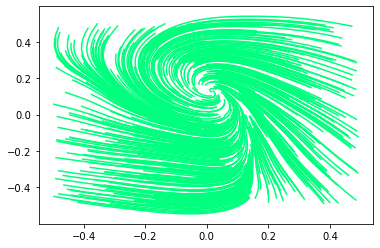

In [11]:
x0_batch = optimizer.sample_initial_state_batch()
zero_noise_trj = torch.zeros(params.batch_size, params.T, 2)
x_trj, u_trj = optimizer.rollout_policy_batch(x0_batch, zero_noise_trj)
x_trj = x_trj.detach().numpy()

plt.figure()
for b in range(params.batch_size):
    plt.plot(x_trj[b,:,0], x_trj[b,:,1], 'springgreen')
plt.show()
plt.close()